# Risk Measurement Project

by Guillaume IDAME KORALAGE

### Librairies

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import percentileofscore

import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [2]:
def resample_market_data(df, frequency) : 
    
    index = dict_tenor[frequency] + 1
    resample_df = df.iloc[-index:, :]
    
    return resample_df.dropna(how = "all", axis = 1).dropna(how = "all", axis = 0)

In [3]:
def get_volatility(df) : 
    frequency_return = df.pct_change().dropna()
    volatility = np.sqrt(252) * frequency_return.std()
    return volatility.dropna()

def get_skew(df) : 
    frequency_return = df.pct_change().dropna()
    skew = df.skew()
    return skew.dropna()

def get_excess_kurtosis(df) : 
    frequency_return = df.pct_change().dropna()
    excess_kurtosis = df.kurt() - 3
    return excess_kurtosis.dropna()

def get_sharpe_ratio(df) : 
    frequency_return = df.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_var(df, alpha = 0.05):
    frequency_return = df.pct_change().dropna()
    dict_var = {}
    for column in frequency_return.columns : 
        dict_var[column] = -np.percentile(frequency_return[column], alpha * 100)
    var = pd.DataFrame.from_dict(dict_var, orient = "index", columns = ["VAR " + str((1-alpha) * 100) + "%"])
    return var

def get_expected_shortfall(df, alpha=0.05):
    frequency_return = df.pct_change().dropna()
    dict_es = {}
    
    for column in frequency_return.columns:
        column_returns = frequency_return[column]
        var = -np.percentile(column_returns, alpha * 100)
        es = -np.mean(column_returns[column_returns <= var])
        dict_es[column] = es
    
    es_df = pd.DataFrame.from_dict(dict_es, orient="index", columns=["ES " + str((1-alpha) * 100) + "%"])
    return es_df

def get_risk_metrics(df) :
    volatility = get_volatility(df).to_frame(name = "Volatility")
    skew = get_skew(df).to_frame(name = "Skewness")
    excess_kurtosis = get_excess_kurtosis(df).to_frame(name = "Excess Kurtosis")
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    var = get_var(df, alpha=0.01)
    expected_shortfall = get_expected_shortfall(df, alpha=0.01)
   

    risk_metrics = pd.concat([volatility,
                              skew, 
                              excess_kurtosis,
                              sharpe_ratio,
                              var,
                              expected_shortfall], axis = 1)
    
    return risk_metrics

### Step 1 : Load Data

In [1]:
path_data = "C:/Users/idame/OneDrive/Documents/Guillaume/Education/EDHEC M2 FENG/Risk Measurement/Risk Measurement - data for group.xlsx"

### Step 2 : Pre Processing

In [5]:
#Data
group_daily_data = pd.read_excel(path_data,  skiprows=9, sheet_name = "daily_data")
group_daily_data.set_index("date", inplace = True)

#outliers over 5 std and forward fill
df_return = group_daily_data.pct_change().dropna()
expanding_z_score = df_return.sub(df_return.expanding().mean()).div(df_return.expanding().std()).dropna()
clean_df_return = df_return[abs(expanding_z_score)<5].ffill().dropna()

#Rebase
rebase_group_daily_data = (1 + clean_df_return).cumprod()

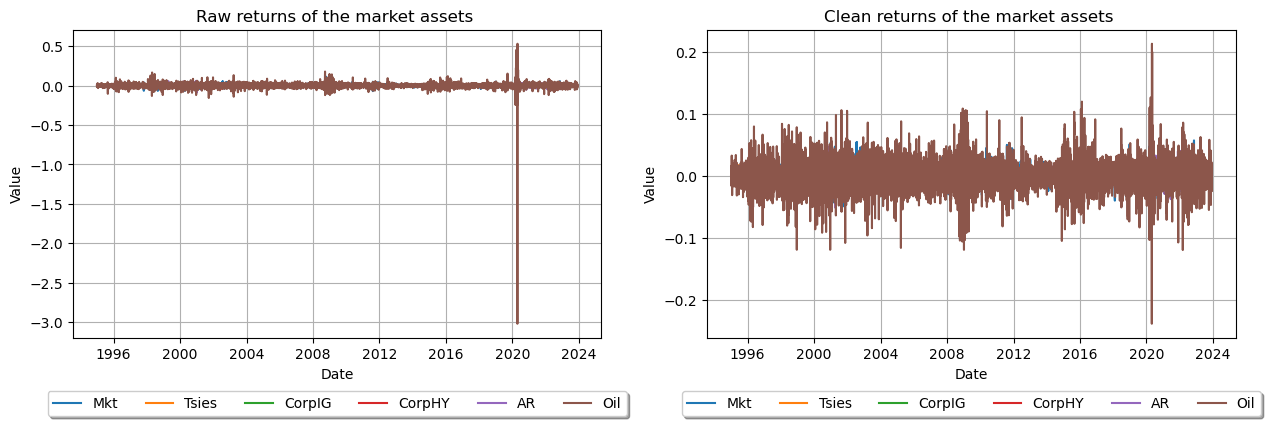

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

axs[0].plot(df_return, label = df_return.columns)
axs[0].set_title("Raw returns of the market assets ")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Date")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[0].grid()

axs[1].plot(clean_df_return, label = clean_df_return.columns)
axs[1].set_title("Clean returns of the market assets ")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Date")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[1].grid()

### Step 3 : Explore Data

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

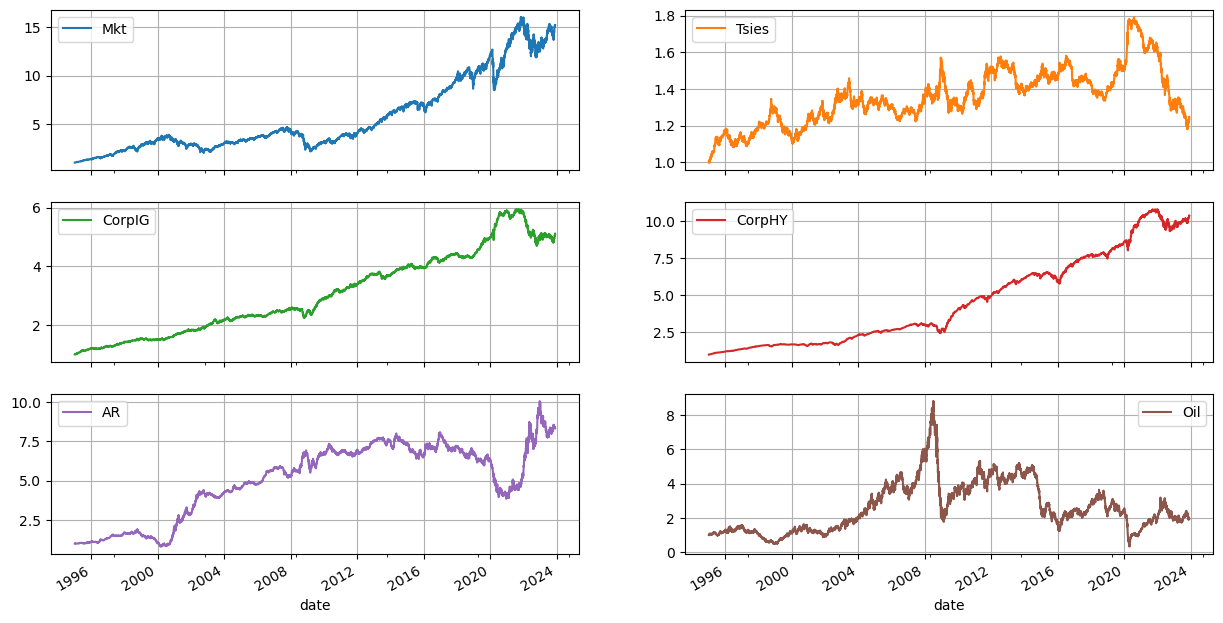

In [7]:
rebase_group_daily_data.plot(subplots = True, grid = True, layout = (3,2), figsize = (15,8))

In [8]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_metrics = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(rebase_group_daily_data, tenor_value)
    dict_tenor_metrics[tenor_value] = get_risk_metrics(resample_adjclose_market_data)

tenor_metrics = pd.concat(dict_tenor_metrics.values(), keys = dict_tenor_metrics.keys(), axis = 1)
tenor_metrics

1W                                                             \
       Volatility  Skewness Excess Kurtosis Sharpe Ratio VAR 99.0%  ES 99.0%   
Mkt      0.033033  1.675271        0.045177     6.179329  0.001994 -0.000085   
Tsies    0.102410  0.363392       -2.569039     1.998880  0.007870 -0.000812   
CorpIG   0.080254 -0.033874       -4.207339     6.482825  0.003337  0.001171   
CorpHY   0.042096  0.486112       -5.060554    12.403484  0.000576  0.000310   
AR       0.012498  0.375649       -4.310786    -8.468495  0.001243  0.000420   
Oil      0.363422  0.201815       -4.120815    -1.925260  0.025605  0.002777   

               1M                                         ...              2Y  \
       Volatility  Skewness Excess Kurtosis Sharpe Ratio  ... Excess Kurtosis   
Mkt      0.117489 -0.740287       -3.517660     9.332154  ...       -3.918377   
Tsies    0.103851 -0.642986       -3.094465     4.495559  ...       -3.374447   
CorpIG   0.080080 -0.233897       -3.621190     7.665142  ...       -1.681494   
CorpHY   0.059711 -0.747619       -2.590009     9.121230  ...       -3.060736   
AR       0.097849  0.729984       -3.517816    -2.597631  ...       -2.112788   
Oil      0.383486  0.445158       -3.738159    -2.586890  ...       -3.104057   

                                                5Y                            \
       Sharpe Ratio VAR 99.0%  ES 99.0% Volatility  Skewness Excess Kurtosis   
Mkt        0.026511  0.035286  0.000091   0.201436 -0.224805       -4.039867   
Tsies     -1.332647  0.012977  0.000778   0.082194 -0.023690       -4.137053   
CorpIG    -0.861165  0.010549  0.000372   0.060295  0.022694       -4.149483   
CorpHY    -0.145155  0.010051  0.000166   0.053324 -0.519139       -3.999152   
AR         1.268677  0.030295 -0.000640   0.201813  0.186323       -4.183994   
Oil        0.303977  0.067477  0.000253   0.466984 -0.514363       -3.237529   

                                         
       Sharpe Ratio VAR 99.0%  ES 99.0%  
Mkt        0.530262  0.037406 -0.000141  
Tsies     -0.180492  0.012426  0.000336  
CorpIG     0.610136  0.010126 -0.000052  
CorpHY     1.170445  0.009256 -0.000053  
AR         0.279378  0.029929  0.000288  
Oil        0.143438  0.080793  0.000705  

[6 rows x 42 columns]

In [9]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}
list_tenor = list(dict_tenor.keys())

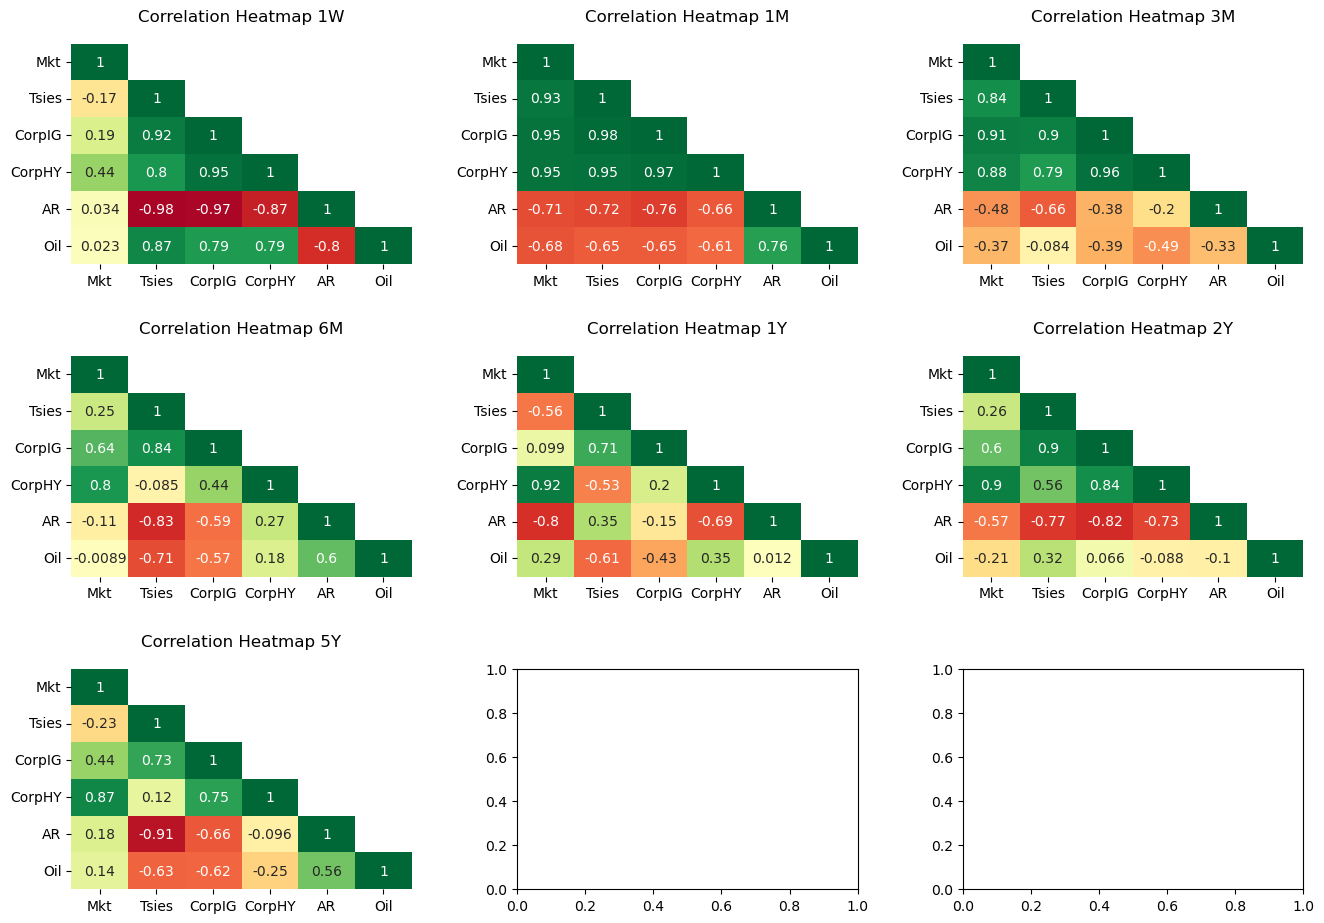

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
fig.tight_layout(pad=4.5)

#1W
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1W"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1W"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,0])
heatmap.set_title('Correlation Heatmap 1W', fontdict={'fontsize':12}, pad=16);

#1M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,1])
heatmap.set_title('Correlation Heatmap 1M', fontdict={'fontsize':12}, pad=16);

#3M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["3M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["3M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,2])
heatmap.set_title('Correlation Heatmap 3M', fontdict={'fontsize':12}, pad=16);

#6M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["6M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["6M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,0])
heatmap.set_title('Correlation Heatmap 6M', fontdict={'fontsize':12}, pad=16);

#1Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,1])
heatmap.set_title('Correlation Heatmap 1Y', fontdict={'fontsize':12}, pad=16);

#2Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["2Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["2Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,2])
heatmap.set_title('Correlation Heatmap 2Y', fontdict={'fontsize':12}, pad=16);

#5Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["5Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["5Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[2,0])
heatmap.set_title('Correlation Heatmap 5Y', fontdict={'fontsize':12}, pad=16);

### Step 4 : Construction Portfolios : Default, Active, Augmented

In [11]:
#Weights
default_weights = [0.5, 0.2, 0.05, 0.05, 0.15, 0.05]
active_weights = [-0.1, 0.15, -0.05, -0.05, 0.10, -0.05]
augmented_weights = [0.40, 0.35, 0, 0, 0.25, 0]

#Breakdown
breakdown_default_portfolio = default_weights * rebase_group_daily_data
breakdown_active_portfolio = active_weights * rebase_group_daily_data
breakdown_augmented_weights_portfolio = augmented_weights * rebase_group_daily_data

#Porfolios
default_portfolio = breakdown_default_portfolio.sum(axis = 1).to_frame(name = "default")
active_portfolio = breakdown_active_portfolio.sum(axis = 1).to_frame(name = "active")
augmented_weights_portfolio = breakdown_augmented_weights_portfolio.sum(axis = 1).to_frame(name = "augmented")

#Aggregated Portfolios
aggregated_portfolios = pd.concat([default_portfolio, active_portfolio, augmented_weights_portfolio], axis = 1)
return_aggregated_portfolios = aggregated_portfolios.pct_change().dropna()

aggregated_portfolios.head()

,default,active,augmented
date,,,
1995-01-04,1.004075,0.000301,1.004376
1995-01-05,1.003616,-0.000874,1.002742
1995-01-06,1.004348,-0.000884,1.003464
1995-01-09,1.003149,-0.000678,1.002472
1995-01-10,1.004361,-0.001193,1.003168


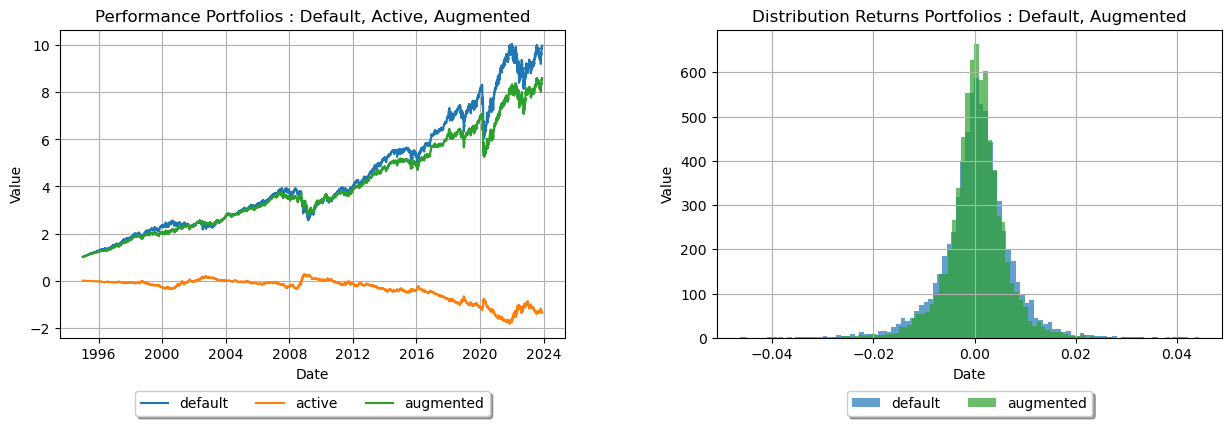

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
axs[0].plot(aggregated_portfolios, label = aggregated_portfolios.columns)
axs[0].set_title("Performance Portfolios : Default, Active, Augmented")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Date")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
axs[0].grid()

aggregated_portfolios[["default"]].pct_change().dropna().hist(bins = 100, alpha = 0.7, ax = axs[1], grid = False, label = "default", color = "#1f77b4")
aggregated_portfolios[["augmented"]].pct_change().dropna().hist(bins = 100, alpha = 0.7, ax = axs[1], grid = False, label = "augmented", color = "#2ca02c")
axs[1].set_title("Distribution Returns Portfolios : Default, Augmented")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Date")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
axs[1].grid()

### Questions

#### Q1 - what is the ex-ante risk profile of the augmented portfolio on Thursday 30-Nov-2023 close and how does this compare against the default mix ?

For tackling this question you have to decide on what risk measures and what parameter settings you deem relevant to capture the ex-ante risks of these portfolios. Motivate your choices and interpret the estimated risk statistics.

#### Volatility (Standard Deviation):
Augmented Portfolio:
Calculate the standard deviation of daily or weekly returns for the augmented portfolio. A higher standard deviation indicates higher volatility.

Default Mix:
Perform the same calculation for the standard deviation of daily or weekly returns for the default mix.

Comparison:
Compare the standard deviations of the augmented portfolio and the default mix. The portfolio with a higher standard deviation is considered to have higher volatility and, hence, higher risk.

#### Skewness:
Augmented Portfolio:
Compute the skewness of the augmented portfolio returns. Positive skewness indicates a longer right tail, while negative skewness indicates a longer left tail.

Default Mix:
Calculate the skewness of the returns for the default mix.

Comparison:
Compare the skewness values. Positive skewness might suggest a potential for higher positive returns but with a caution about extreme positive returns. Negative skewness may indicate a higher risk of extreme negative returns.

#### Excess Kurtosis:
Augmented Portfolio:
Calculate the excess kurtosis of the augmented portfolio returns. Positive excess kurtosis suggests fat tails, while negative excess kurtosis suggests thinner tails.

Default Mix:
Compute the excess kurtosis for the returns of the default mix.

Comparison:
Compare the excess kurtosis values. Positive excess kurtosis may indicate a portfolio with a higher likelihood of extreme returns, contributing to tail risk.

#### Sharpe Ratio:
Augmented Portfolio:
Compute the Sharpe Ratio, which measures the risk-adjusted return for the augmented portfolio.

Default Mix:
Calculate the Sharpe Ratio for the default mix.

Comparison:
Compare the Sharpe Ratios. A higher Sharpe Ratio suggests better risk-adjusted performance.

#### Value at Risk (VaR):
Augmented Portfolio:
Calculate VaR at a specified confidence level (e.g., 95% or 99%) for the augmented portfolio.

Default Mix:
Perform the same calculation for VaR for the default mix.

Comparison:
Compare the VaR values. A higher VaR implies a higher potential loss, indicating higher risk.

#### Conditional Value at Risk (CVaR or Expected Shortfall):
Augmented Portfolio:
Calculate CVaR at the same confidence level as VaR for the augmented portfolio.

Default Mix:
Compute CVaR for the default mix.

Comparison:
Compare the CVaR values. Higher CVaR indicates higher risk in the tail distribution of potential losses.

In [13]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_metrics = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(aggregated_portfolios, tenor_value)
    dict_tenor_metrics[tenor_value] = get_risk_metrics(resample_adjclose_market_data)

tenor_metrics = pd.concat(dict_tenor_metrics.values(), keys = dict_tenor_metrics.keys(), axis = 1)
tenor_metrics

1W                                                   \
          Volatility  Skewness Excess Kurtosis Sharpe Ratio VAR 99.0%   
default     0.021397  1.445251       -0.326164     8.410752  0.001278   
active      0.039365 -0.769463       -4.547601    12.770149  0.000649   
augmented   0.021894  1.553418        0.067084     5.874967  0.001392   

                            1M                                         ...  \
           ES 99.0% Volatility  Skewness Excess Kurtosis Sharpe Ratio  ...   
default   -0.000299   0.096928 -0.768136       -3.438020     8.633698  ...   
active     0.000470   0.155233  0.627708       -3.632083    10.281032  ...   
augmented -0.000034   0.091136 -0.808876       -3.373653     7.906781  ...   

                       2Y                                          5Y  \
          Excess Kurtosis Sharpe Ratio VAR 99.0%  ES 99.0% Volatility   
default         -3.607155     0.119889  0.025289  0.000017   0.147380   
active          -2.969811    -0.165007  0.050717  0.000848   0.288818   
augmented       -2.756075     0.301907  0.020199  0.000104   0.133859   

                                                                      
           Skewness Excess Kurtosis Sharpe Ratio VAR 99.0%  ES 99.0%  
default   -0.333660       -4.133011     0.560732  0.027025 -0.000124  
active    -0.391211       -3.790648     0.514160  0.049869 -0.000044  
augmented -0.273797       -4.214057     0.565247  0.024582 -0.000114  

[3 rows x 42 columns]

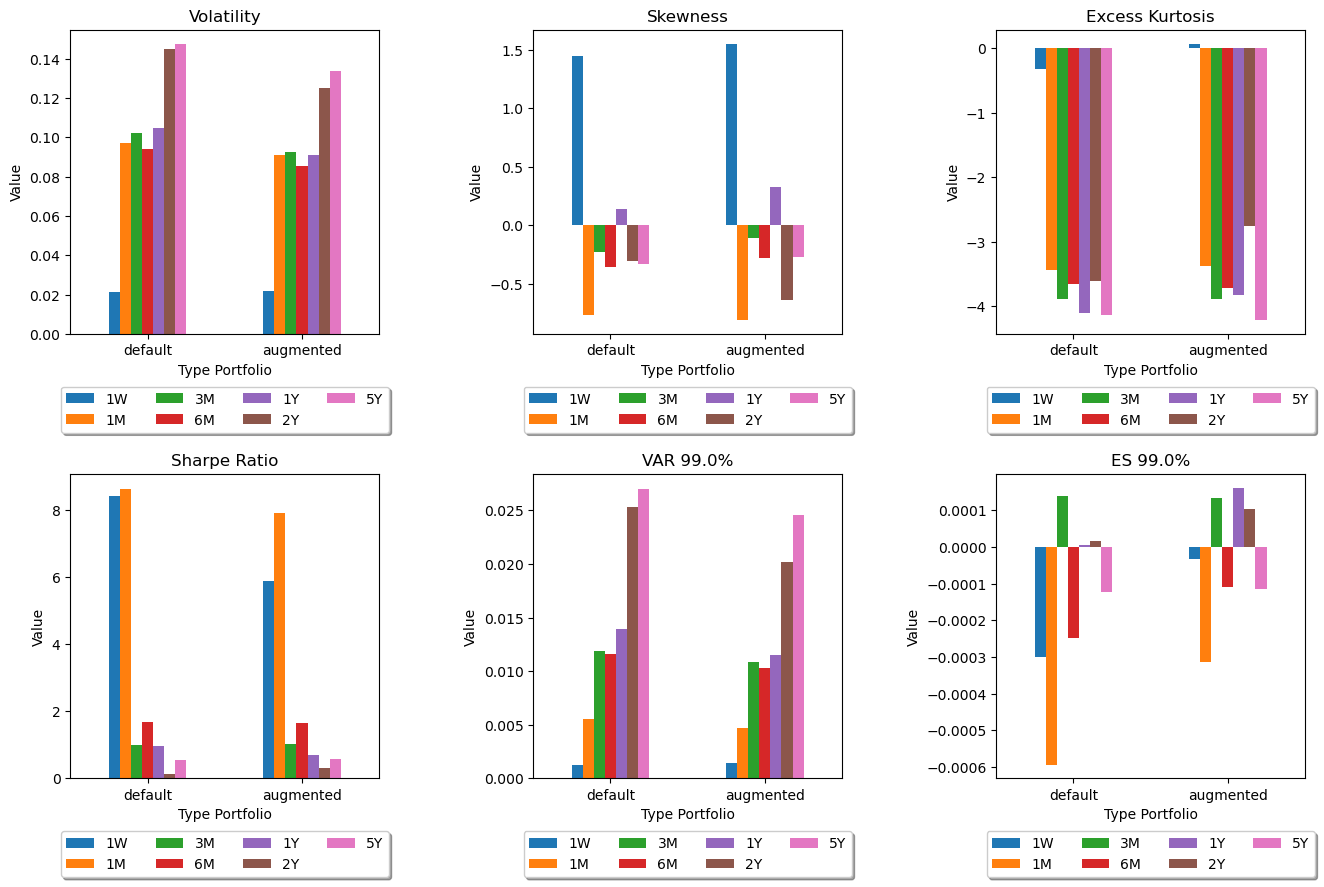

In [14]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
fig.tight_layout(pad=8.0)

tenor_metrics.loc[["default", "augmented"]].xs("Volatility", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,0])
axs[0,0].set_title("Volatility")
axs[0,0].set_xlabel("Type Portfolio")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Skewness", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,1])
axs[0,1].set_title("Skewness")
axs[0,1].set_xlabel("Type Portfolio")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Excess Kurtosis", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,2])
axs[0,2].set_title("Excess Kurtosis")
axs[0,2].set_xlabel("Type Portfolio")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Sharpe Ratio", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,0])
axs[1,0].set_title("Sharpe Ratio")
axs[1,0].set_xlabel("Type Portfolio")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("VAR 99.0%", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,1])
axs[1,1].set_title("VAR 99.0%")
axs[1,1].set_xlabel("Type Portfolio")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("ES 99.0%", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,2])
axs[1,2].set_title("ES 99.0%")
axs[1,2].set_xlabel("Type Portfolio")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

In [15]:
def get_mcr(returns, list_weights) : 
    cov_matrix = returns.cov() * 252
    portfolio_weights = np.array(list_weights)
    portfolio_variance = np.dot(portfolio_weights.T, np.dot(portfolio_weights, portfolio_weights))
    portfolio_vol = np.sqrt(portfolio_variance)  
    asset_contribution = np.dot(cov_matrix, portfolio_weights) * portfolio_weights
    mcr = asset_contribution / portfolio_vol
    mcr_data = pd.DataFrame(mcr, index = returns.columns, columns  = ["MCR"])
    return mcr_data

def get_multi_mcr(returns, list_weights, list_type_portfolio) : 
    
    dict_mcr = {}
    for weights, type_portfolio in zip(list_weights, list_type_portfolio) :
        mcr_portfolio = get_mcr(returns, weights)
        mcr_portfolio.columns = [type_portfolio]
        dict_mcr[type_portfolio] = mcr_portfolio

    mcr_data = pd.concat(dict_mcr.values(), axis = 1)
    
    return mcr_data

In [16]:
default_weights = [0.5, 0.2, 0.05, 0.05, 0.15, 0.05]
active_weights = [-0.1, 0.15, -0.05, -0.05, 0.10, -0.05]
augmented_weights = [0.40, 0.35, 0, 0, 0.25, 0]

list_weights = [default_weights, augmented_weights]
list_type_portfolio = ["default", "augmented"]

dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_mcr = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(clean_df_return, tenor_value)
    dict_tenor_mcr[tenor_value] = get_multi_mcr(resample_adjclose_market_data, list_weights, list_type_portfolio)

tenor_mcr = pd.concat(dict_tenor_mcr.values(), keys = dict_tenor_mcr.keys(), axis = 1)
tenor_mcr

C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_11868\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local

1W                  1M                  3M                  6M  \
         default augmented   default augmented   default augmented   default   
Mkt    -0.000331 -0.000377  0.011097  0.008662  0.012021  0.008773  0.010038   
Tsies   0.001578  0.001754  0.004212  0.005501  0.003424  0.004634  0.002698   
CorpIG  0.000601       NaN  0.001757       NaN  0.001514       NaN  0.001155   
CorpHY  0.000378       NaN  0.001635       NaN  0.001343       NaN  0.001038   
AR     -0.000118 -0.000166  0.001782  0.001855  0.000020  0.000565  0.000283   
Oil     0.003569       NaN  0.004332       NaN  0.001400       NaN  0.002292   

                        1Y                  2Y                  5Y            
       augmented   default augmented   default augmented   default augmented  
Mkt     0.006861  0.012901  0.007119  0.024000  0.012942  0.024817  0.014363  
Tsies   0.003722  0.001664  0.002892  0.002046  0.003312 -0.000036  0.000855  
CorpIG       NaN  0.000901       NaN  0.001044       NaN  0.000440       NaN  
CorpHY       NaN  0.001129       NaN  0.001552       NaN  0.001218       NaN  
AR      0.001364 -0.000791  0.001419 -0.002853  0.001817  0.000773  0.004464  
Oil          NaN  0.004254       NaN  0.005860       NaN  0.008377       NaN

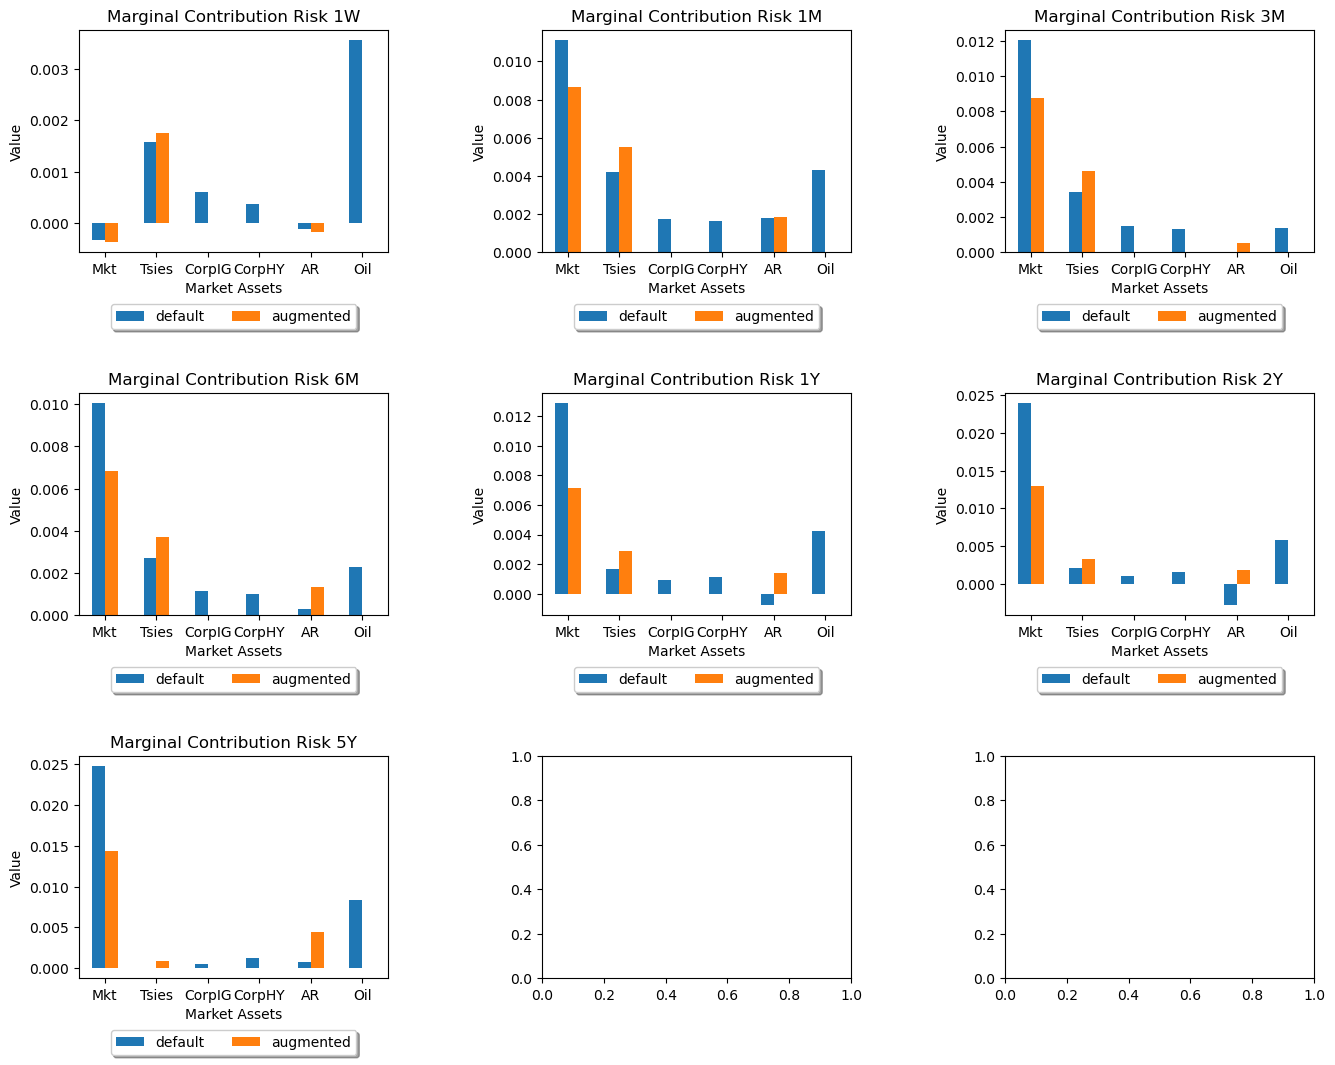

In [17]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.tight_layout(pad=8.0)

tenor_mcr.xs("1W", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,0], rot = 0)
axs[0,0].set_title("Marginal Contribution Risk 1W")
axs[0,0].set_xlabel("Market Assets")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("1M", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,1], rot = 0)
axs[0,1].set_title("Marginal Contribution Risk 1M")
axs[0,1].set_xlabel("Market Assets")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("3M", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,2], rot = 0)
axs[0,2].set_title("Marginal Contribution Risk 3M")
axs[0,2].set_xlabel("Market Assets")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("6M", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,0], rot = 0)
axs[1,0].set_title("Marginal Contribution Risk 6M")
axs[1,0].set_xlabel("Market Assets")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("1Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,1], rot = 0)
axs[1,1].set_title("Marginal Contribution Risk 1Y")
axs[1,1].set_xlabel("Market Assets")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("2Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,2], rot = 0)
axs[1,2].set_title("Marginal Contribution Risk 2Y")
axs[1,2].set_xlabel("Market Assets")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("5Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[2,0], rot = 0)
axs[2,0].set_title("Marginal Contribution Risk 5Y")
axs[2,0].set_xlabel("Market Assets")
axs[2,0].set_ylabel("Value")
axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

#### Q2 - how do the tail risks of the portfolio change after implementing the active positions ?

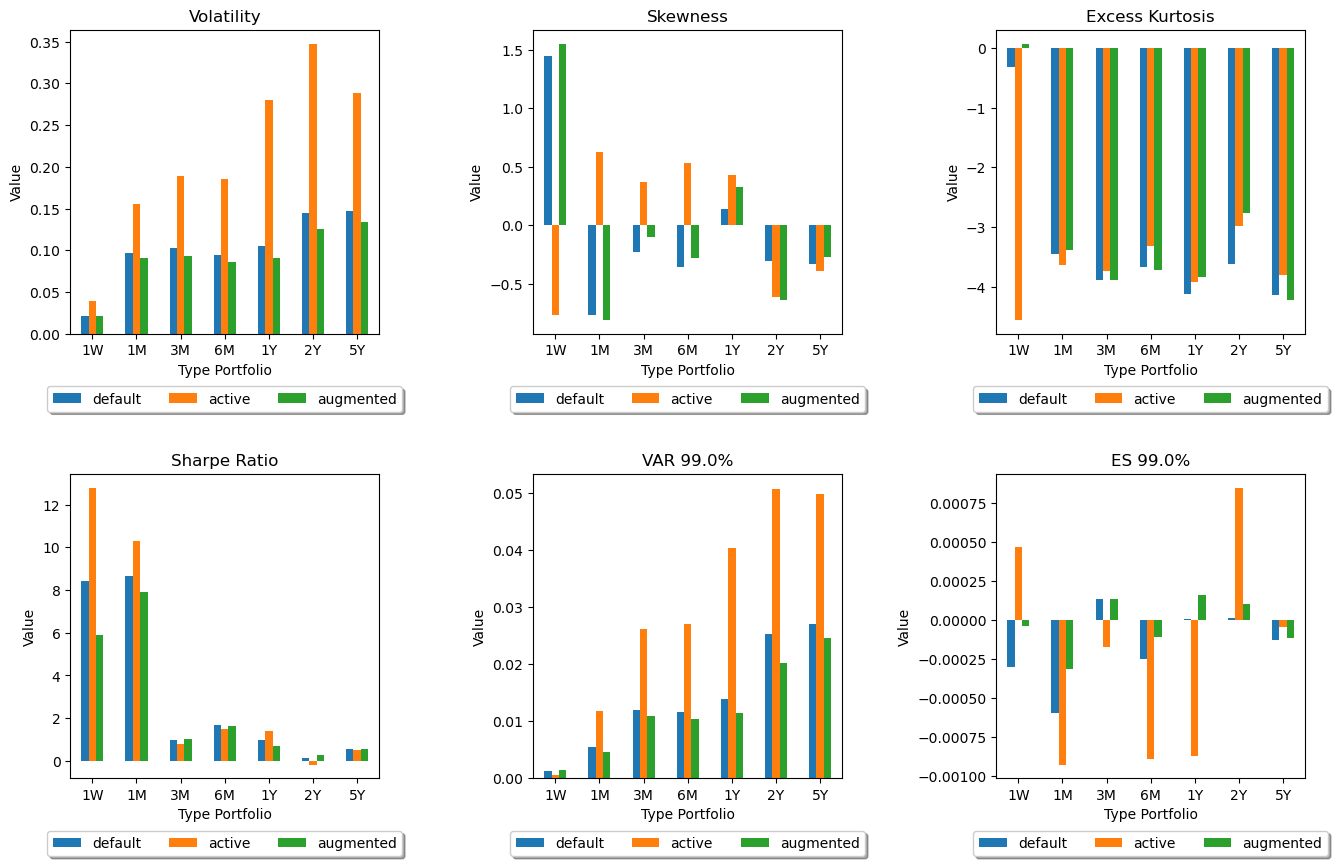

In [18]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
fig.tight_layout(pad=8.0)

tenor_metrics.xs("Volatility", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,0])
axs[0,0].set_title("Volatility")
axs[0,0].set_xlabel("Type Portfolio")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

tenor_metrics.xs("Skewness", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,1])
axs[0,1].set_title("Skewness")
axs[0,1].set_xlabel("Type Portfolio")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

tenor_metrics.xs("Excess Kurtosis", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,2])
axs[0,2].set_title("Excess Kurtosis")
axs[0,2].set_xlabel("Type Portfolio")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

tenor_metrics.xs("Sharpe Ratio", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,0])
axs[1,0].set_title("Sharpe Ratio")
axs[1,0].set_xlabel("Type Portfolio")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

tenor_metrics.xs("VAR 99.0%", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,1])
axs[1,1].set_title("VAR 99.0%")
axs[1,1].set_xlabel("Type Portfolio")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

tenor_metrics.xs("ES 99.0%", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,2])
axs[1,2].set_title("ES 99.0%")
axs[1,2].set_xlabel("Type Portfolio")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=3)

#### Q3 - how is this augmented portfolio expected to perform in stressed market scenarios and how does this compare against the default mix ?

Regarding the relevant time horizon(s) you have the following information :
- for investors, the recommended holding period of the Total Return fund is 3-5 years;
- official fund performance reporting is monthly (or 4-weekly);
- the PM can implement (active) portfolio trades once a week;
- a regulatory daily 99% VaR must be reported on a daily basis.
